In [30]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import models, layers
from tensorflow.keras.optimizers import Adam

In [3]:
def getfile(filePath):
    return filePath.split('\\')[-1]

In [4]:
def InitData(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, "driving_log.csv"), names = columns)
    data['Center'] = data['Center'].apply(getfile)
    print('Total Images Imported', data.shape[0])
    return data

In [5]:
def balanceDataSet(data, display=True):
    nBin = 21
    samplesPerBin = 1000
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    removeList = []
    for i in range(nBin):
        binDataList = []
        for j in range(len(data['Steering'])):
            if data['Steering'][j] >= bins[i] and data['Steering'][j] <= bins[i + 1]:
                binDataList.append(j)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeList.extend(binDataList)
        
    print('Removed Images: ', len(removeList))
    data.drop(data.index[removeList], inplace=True)
    print('Remaining Images: ', len(data))
    
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist,width=0.05)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    return data

In [28]:
# Load images and steering angles
def load_images_and_steering(data, img_folder='IMG'):
    images = []
    steerings = []
    for i in range(len(data)):
        img_path = os.path.join(img_folder, data.iloc[i]['Center'])
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            # images.append(image)
            # steerings.append(float(data.iloc[i]['Steering']))
            if image is not None and image.ndim == 3 and image.shape[2] == 3:
                images.append(image)
                steerings.append(float(data.iloc[i]['Steering']))
            else:
                print(f"Skipping image {img_path}: invalid shape or None")
    return np.array(images), np.array(steerings)

In [29]:
def img_preprocess(img, index):
    if img is None:
        print(f"[Preprocess Error] Image at index {index} is None")
        return None
    if img.ndim != 3:
        print(f"[Preprocess Error] Image at index {index} has invalid ndim: {img.ndim}")
        return None
    if img.shape[2] != 3:
        print(f"[Preprocess Error] Image at index {index} has shape: {img.shape}")
        return None
    
    # Crop image to Height[60:135] and the whole width
    cropped_img = img[60:135, :] # [H:W]
    
    # Convert img to YUV color space
    yuv_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2YUV)

    # Resize to 200x66 (WxH)
    resized_yuv = cv2.resize(yuv_cropped_img, (200, 66)) # (W, H)

    # Normalize pixel values in [0:255] to [0:1] with division
    resized_yuv_norm = resized_yuv / 255

    # Blur with (5,5) kernel and inferred sigma
    processed_img = cv2.GaussianBlur(resized_yuv_norm, (5,5), 0)

    return processed_img

In [32]:
def create_batches(images, steerings, batch_size=32, shuffle_data=True):
    """
    Creates batches of preprocessed images and steering angles
    Args:
        images: Preprocessed images array (n_samples, height, width, channels)
        steerings: Corresponding steering angles (n_samples,)
        batch_size: Number of samples per batch
        shuffle_data: Whether to shuffle the data before batching
    Returns:
        Generator yielding (X_batch, y_batch) tuples
    """
    num_samples = len(images)
    
    if shuffle_data:
        images, steerings = shuffle(images, steerings)
    
    # Calculate number of full batches
    num_batches = num_samples // batch_size
    
    for batch_idx in range(0, num_batches * batch_size, batch_size):
        X_batch = images[batch_idx:batch_idx + batch_size]
        y_batch = steerings[batch_idx:batch_idx + batch_size]
        yield X_batch, y_batch
    
    # Handle remaining samples (if any)
    if num_samples % batch_size != 0:
        X_batch = images[num_batches * batch_size:]
        y_batch = steerings[num_batches * batch_size:]
        yield X_batch, y_batch

In [17]:
def driving_angle_model():
    net = models.Sequential([
                        # Original size passing the first CNN
                        # With 24 filters, this extracts features such as edges and textures
                        layers.Conv2D(filters=24, kernel_size=(5, 5), activation='relu', input_shape=(66,200,3)),
                        
                        # With 36 filters, this extracts deeper features such as lane curves
                        layers.Conv2D(filters=36, kernel_size=(5, 5), activation='relu'),

                        # With 48 layers, this extracts high level features such as lane patterns
                        layers.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),

                        # With 64 layers, this extracts fine grained features
                        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

                        # Once again at 64 filters, this extracts the previous features once more
                        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

                        # Flatten the result array to a 1D array to match size for Dense
                        layers.Flatten(),

                        # Separate 3 Dense compressions on result layer
                        # Compressing with large number of neurons will overfit, and too low will underfit or lose info
                        layers.Dense(100, activation='relu'),
                        layers.Dense(50, activation='relu'),
                        layers.Dense(1)
                        ])
    
    optimizer = Adam(learning_rate=0.01)

    # We want to determine the driving angle based on picture. Therefore, this is a regression problem
    net.compile(optimizer, loss='mse')

    return net;

Total Images Imported 4221


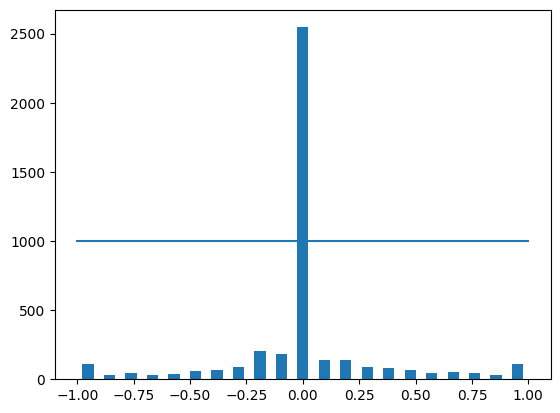

Removed Images:  1546
Remaining Images:  2675


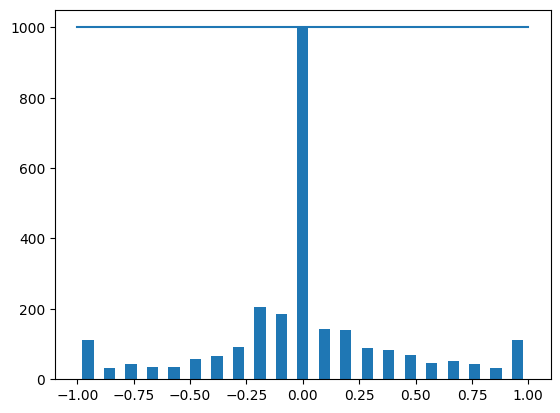

c:\Users\Julian Huang\OneDrive\Desktop\Seneca\Visual Studio Code\CVI620\CVI620_virtual_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Julian Huang\OneDrive\Desktop\Seneca\Visual Studio Code\CVI620\CVI620_virtual_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
62/67 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 290596.4062

KeyboardInterrupt: 

In [31]:
data = InitData('.')
data = balanceDataSet(data, display=True)

images, steerings = load_images_and_steering(data)

# processed_images = np.stack([img_preprocess(images) for img in images])

processed_images = []
for i, img in enumerate(images):
    proc = img_preprocess(img, index=i)
    if proc is not None:
        processed_images.append(proc)

processed_images = np.array(processed_images)

X_train, X_test, y_train, y_test = train_test_split(processed_images, steerings, test_size=0.2, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

net = driving_angle_model()

# Fits the neural network with data
# Batch size between 2-32 can consistently be stable and reliable (source: Revisiting Small Batch Training for Deep Neural Networks)
H = net.fit(aug.flow(X_train, y_train), validation_data=(X_test, y_test), batch_size=32, epochs=100)

In [ ]:
plt.plot(H.history["accuracy"], label="train")
plt.plot(H.history["val_accuracy"], label="test")
plt.plot(H.history["loss"], label="train loss")
plt.plot(H.history["val_loss"], label="test loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")